In [224]:
import sys
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import math

# Adjust the path for c2qa and bosonic-qiskit modules
module_path = os.path.abspath(os.path.join('..', '..', '..'))  # Moves three directories up
if module_path not in sys.path:
    sys.path.append(module_path)

# Add the `playground` directory to the Python path
playground_path = Path.cwd().parent.parent  # Move two levels up to `playground`
if str(playground_path) not in sys.path:
    sys.path.append(str(playground_path))


# Qiskit and related imports
import qiskit
from qiskit.quantum_info import state_fidelity, Statevector, SparsePauliOp, Operator, Clifford
from qiskit.circuit import QuantumCircuit
from qiskit.circuit.library import PauliEvolutionGate, UnitaryGate
from qiskit.synthesis import LieTrotter, SuzukiTrotter
import qutip as qt
from qiskit import transpile


# Project-specific imports
import c2qa
import c2qa.util as util


# A YUKAWA THEORY: SCALAR FIELDS COUPLED TO (STAGGERED) FERMIONS
[ref](https://arxiv.org/pdf/2104.09346)

## Gate Count Summary for the Hybrid Qubit–Oscillator Architecture

We first provide a summary of the gate counts arising from the decomposition of the Hamiltoian of 1D 
lattice-regularized Yukawa theory  (Eq 19 of ref) after mapping to spin (qubit) and boson (oscillator) degrees of freedom for a lattice with $N$ sites.

### 1. Spin–Spin Interaction (XX + YY)

The combined term is
$$
H^{(I)} = \frac{1}{4b} \sum_{j=1}^{N} \Bigl( \sigma^x_j \sigma^x_{j+1} + \sigma^y_j \sigma^y_{j+1} \Bigr),
$$
with periodic boundary conditions (i.e. $\sigma^x_{N+1}\equiv\sigma^x_1$, etc.).  
- **$N$ two-qubit gates (XX+YY gates):** one for each nearest-neighbor pair.

### 2. Staggered Mass Term ($R_z$ Rotations)

The staggered mass term is given by
$$
H^{(II)} = \frac{m_\psi}{2} \sum_{j=1}^{N} (-1)^j\,\sigma^z_j + \text{const.}
$$
This corresponds to a rotation about the $z$-axis for each qubit, with an alternating sign.  
- **$N$ single-qubit $R_z$ rotations:** one per lattice site.

### 3. Boson–Spin Coupling

The boson–spin coupling term is
$$
H^{(III)} = \sqrt{\frac{g^2}{b}\,\frac{1}{8N}} \sum_{j=1}^{N} \Bigl( I_j + \sigma^z_j \Bigr)
\sum_{m=1}^{N} \frac{1}{\sqrt{\epsilon_m}}
\Bigl( a^\dagger_{m}\,e^{-i\frac{2\pi j}{N}\left(m-\frac{N}{2}-1\right)} + a_{m}\,e^{i\frac{2\pi j}{N}\left(m-\frac{N}{2}-1\right)} \Bigr).
$$

In the hybrid qubit–oscillator architecture, $(I + \sigma^z_j)(a^\dagger + a)$ maps to:
- **A controlled displacement gate** $e^{\sigma^z_j (a^\dagger+a)}$
- **An unconditional displacement gate** $e^{(a^\dagger+a)}$.

Since the sum runs over every qubit ($j=1,\dots,N$) and every bosonic mode ($m=1,\dots,N$), we have:

- **$N^2$ controlled displacement gates:** one for each $(j,m)$ pair.
- **$N^2$ unconditional displacement gates:** one for each $(j,m)$ pair.

### 4. Bosonic Free Hamiltonian
The free bosonic Hamiltonian is
$$
H^{(IV)}= \sum_{m=1}^{N} \epsilon_m \Bigl( a^\dagger_{m}\,a_{m} + \frac{1}{2} \Bigr).
$$

- **$N$ bosonic phase rotation gates**

### Overall 

- **Spin–Spin (XX + YY) gates:** $N$  
- **$R_z$ rotations:** $N$  
- **Controlled displacement gates:** $N^2$  
- **Unconditional displacement gates:** $N^2$  
- **Bosonic phase rotations:** $N$

## Two-Site Example
$$
\begin{aligned}
H &= \frac{1}{2b} \Bigl[ (X_1 X_2 + Y_1 Y_2) \Bigr] \\
&\quad + \frac{m_\psi}{2} \Bigl[ -Z_1 + Z_2 \Bigr] + \text{const.} \\
&\quad + \sqrt{\frac{g^2}{b} \frac{1}{16}} \Biggl\{ 
(I_1+Z_1) \Biggl[ -\frac{1}{\sqrt{\epsilon_1}} \Bigl( a^\dagger_{1}+a_{1} \Bigr)
+ \frac{1}{\sqrt{\epsilon_2}} \Bigl( a^\dagger_{2}+a_{2} \Bigr) \Biggr] \\
&\quad\quad + (I_2+Z_2) \Biggl[ \frac{1}{\sqrt{\epsilon_1}} \Bigl( a^\dagger_{1}+a_{1} \Bigr)
+ \frac{1}{\sqrt{\epsilon_2}} \Bigl( a^\dagger_{2}+a_{2} \Bigr) \Biggr]
\Biggr\} \\
&\quad + \epsilon_1 \Bigl( a^\dagger_{1}\,a_{1} + \frac{1}{2} \Bigr)
+ \epsilon_2 \Bigl( a^\dagger_{2}\,a_{2} + \frac{1}{2} \Bigr).
\end{aligned}
$$


In [225]:
def fSim(theta):
    """
    Create an fSim gate defined as U(t)=exp(-itheta(XX+YY)).
    """
    
    U = np.array([
        [1,               0,               0, 0],
        [0,  np.cos(theta/2), -1j * np.sin(theta/2), 0],
        [0, -1j * np.sin(theta/2),  np.cos(theta/2), 0],
        [0,               0,               0, 1]
    ])
    return UnitaryGate(U, label="fSim")


In [ ]:
def create_quantum_circuit(num_sites=2, num_qubits_per_qumode=3):
    """Create and initialize the circuit"""
    # Create registers
    qmr = c2qa.QumodeRegister(num_qumodes=num_sites, 
                             num_qubits_per_qumode=num_qubits_per_qumode)
    qbr = qiskit.QuantumRegister(num_sites)
    circuit = c2qa.CVCircuit(qmr, qbr)
    
    return circuit, qmr, qbr

def two_site_circ(circuit, qmr, qbr, b, m, g, eps1, eps2, dt, steps):
    for step in range(steps):
        # Hopping term
        fsim_gate = fSim((2*dt/b))
        circuit.append(fsim_gate, [qbr[0], qbr[1]])
        # Staggerd fermion terms
        circuit.rz(-m*dt, qbr[0])
        circuit.rz(m*dt, qbr[1])

        # Coupling terms
        prefactor = np.sqrt((g**2*b/(16)))
        # 1->1
        circuit.cv_c_d( -1j*prefactor * (-1/np.sqrt(eps1)) * dt, qmr[0], qbr[0]) 
        circuit.cv_d( -1j*prefactor * (-1/np.sqrt(eps1)) * dt, qmr[0])
        # 1->2
        circuit.cv_c_d(-1j * prefactor * (1/np.sqrt(eps2)) * dt, qmr[1], qbr[0]) 
        circuit.cv_d(-1j * prefactor * (1/np.sqrt(eps2)) * dt, qmr[1]) 
        # 2->1
        circuit.cv_c_d(-1j * prefactor * (1/np.sqrt(eps1)) * dt, qmr[0], qbr[1]) 
        circuit.cv_d(-1j * prefactor * (1/np.sqrt(eps1)) * dt, qmr[0]) 
        # 2->2
        circuit.cv_c_d(-1j * prefactor * (1/np.sqrt(eps2)) * dt, qmr[1], qbr[1]) 
        circuit.cv_d(-1j * prefactor * (1/np.sqrt(eps2)) * dt, qmr[1]) 
        
        # onsite boson potential
        circuit.cv_r(eps1 * dt, qmr[0])
        circuit.cv_r(eps2 * dt, qmr[1])

    return circuit

def run_simulation(circuit):
    state, _, _ = c2qa.util.simulate(circuit)
    return state

def simulate_yukawa(num_sites, num_qubits_per_qumode, b, m, g, eps1, eps2, dt, steps ):
    """
    Simulate the two-site yukawa model using a Trotter decomposition.
    """
    num_sites = 2
    
    # Create and initialize the circuit
    circuit, qmr, qbr = create_quantum_circuit(num_sites, num_qubits_per_qumode)
    
    # Apply Trotter steps
    circuit = two_site_circ(circuit, qmr, qbr, b, m, g, eps1, eps2, dt, steps)
    
    # Run the simulation
    state = run_simulation(circuit)
    
    return state

In [299]:
def qutip_2site_yukawa(b=1.0, m_psi=1.0, g=1.0, epsilon1=1.0, epsilon2=1.0, N_b=8,
                         t_max=5, num_steps=100):
    """
    """
    import qutip as qt
    
    # Time vector
    times = np.linspace(0, t_max, num_steps)
    
    # Qubit initialization (2 qubits)
    psi_qubit = qt.tensor(qt.basis(2, 0), qt.basis(2, 0))
    
    # Boson initialization for both modes
    psi_b1 = qt.basis(N_b, 0)
    psi_b2 = qt.basis(N_b, 0)
    
    # Full initial state: ordering is [qubits, boson mode 1, boson mode 2]
    psi0 = qt.tensor(psi_qubit, psi_b1, psi_b2)
    
    # Define identities for embedding
    I_q = qt.tensor(qt.qeye(2), qt.qeye(2))  # Identity in qubit space
    I_b = qt.qeye(N_b)
    I_full = qt.tensor(I_q, I_b, I_b)
    
    # Qubit operators 
    X1 = qt.tensor(qt.sigmax(), qt.qeye(2))
    X2 = qt.tensor(qt.qeye(2), qt.sigmax())
    Y1 = qt.tensor(qt.sigmay(), qt.qeye(2))
    Y2 = qt.tensor(qt.qeye(2), qt.sigmay())
    Z1 = qt.tensor(qt.sigmaz(), qt.qeye(2))
    Z2 = qt.tensor(qt.qeye(2), qt.sigmaz())
    
    # Embed qubit operators into full space 
    X1_full = qt.tensor(X1, I_b, I_b)
    X2_full = qt.tensor(X2, I_b, I_b)
    Y1_full = qt.tensor(Y1, I_b, I_b)
    Y2_full = qt.tensor(Y2, I_b, I_b)
    Z1_full = qt.tensor(Z1, I_b, I_b)
    Z2_full = qt.tensor(Z2, I_b, I_b)
    
    # Qubit-qubit coupling term: 1/(2*b)*(X1X2 + Y1Y2)
    H1 = (1/(2*b)) * (X1_full * X2_full + Y1_full * Y2_full)

    # Qubit mass term (m_psi/2)*(-Z1 + Z2)
    H2 = (m_psi/2) * (-Z1_full + Z2_full)
    
    # Bosonic operators for each mode
    a1 = qt.destroy(N_b)
    a2 = qt.destroy(N_b)
    
    # Embed bosonic operators
    a1_full = qt.tensor(I_q, a1, I_b)
    a2_full = qt.tensor(I_q, I_b, a2)
    
    # Construct (a + adag) combinations
    A1 = a1_full + a1_full.dag()
    A2 = a2_full + a2_full.dag()
    
    # Construct (I+Z) operators acting on individual qubits.
    # For qubit 1: act as (I+Z) on qubit 1 and identity on qubit 2.
    op1 = qt.tensor(qt.qeye(2) + qt.sigmaz(), qt.qeye(2))
    # For qubit 2: act as identity on qubit 1 and (I+Z) on qubit 2.
    op2 = qt.tensor(qt.qeye(2), qt.qeye(2) + qt.sigmaz())
    
    op1_full = qt.tensor(op1, I_b, I_b)
    op2_full = qt.tensor(op2, I_b, I_b)
    
    # Boson-qubit coupling term.
    #   coupling1 = -1/sqrt(epsilon1)*(a1+a1dag) + 1/sqrt(epsilon2)*(a2+a2dag)
    #   coupling2 =  1/sqrt(epsilon1)*(a1+a1dag) + 1/sqrt(epsilon2)*(a2+a2dag)
    coupling1 = - (1/np.sqrt(epsilon1)) * A1 + (1/np.sqrt(epsilon2)) * A2
    coupling2 =   (1/np.sqrt(epsilon1)) * A1 + (1/np.sqrt(epsilon2)) * A2

    H_c = np.sqrt((g**2 *b /(16))) * (op1_full * coupling1 + op2_full * coupling2)

    # Boson potential
    H_b = epsilon1 * (a1_full.dag() * a1_full + 0.5 * I_full) \
        + epsilon2 * (a2_full.dag() * a2_full + 0.5 * I_full)
    
    # Total Hamiltonian
    H = H1 + H2 + H_c + H_b
    
    proj = psi0 * psi0.dag()

    # Solve dynamics using mesolve 
    result = qt.mesolve(H, psi0, times, [], [proj])
    return result


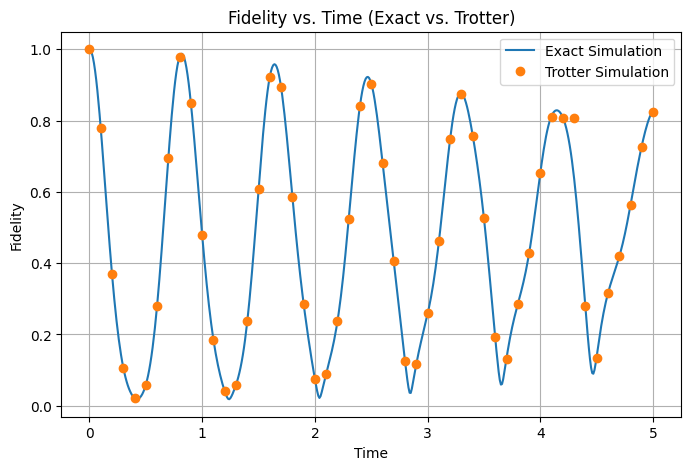

In [ ]:
from scipy.sparse import SparseEfficiencyWarning
import warnings
from qutip import fidelity as qt_fidelity, Qobj
warnings.filterwarnings("ignore", category=SparseEfficiencyWarning)

num_sites = 2
num_qubits_per_qumode = 3
b = 1
m = 1
g = 5*np.sqrt(2)
eps1 = 3.297
eps2 = 1
t_max = 5.0

# Exact Simulation 
dt_exact = 0.01
num_steps_exact = int(t_max / dt_exact) + 1

result_exact = qutip_2site_yukawa(b=b, m_psi=m, g=g, epsilon1=eps1, epsilon2=eps2,
                                  N_b=2**num_qubits_per_qumode, t_max=t_max, num_steps=num_steps_exact)
target_state = result_exact.states[0]

fidelities_exact = [qt.fidelity(state, target_state) for state in result_exact.states]
times_exact = np.linspace(0, t_max, num_steps_exact)

# Trotter Simulation 
dt_trotter = 0.1
times_trotter = np.arange(0, t_max + dt_trotter, dt_trotter)
fidelities_trotter = []

for final_time in times_trotter:
    # Number of Trotter steps
    steps = int(final_time / dt_trotter)
    state = simulate_yukawa(num_sites, num_qubits_per_qumode, b, m, g, eps1, eps2, dt_trotter, steps)
    
    state_qt = Qobj(state, dims=target_state.dims)
    fid = qt_fidelity(target_state, state_qt)
    fidelities_trotter.append(fid)

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(times_exact, fidelities_exact, linestyle='-', label='Exact Simulation')
plt.plot(times_trotter, fidelities_trotter, marker='o', linestyle='None', label='Trotter Simulation')
plt.xlabel("Time")
plt.ylabel("Fidelity")
plt.title("Fidelity vs. Time (Exact vs. Trotter)")
plt.grid(True)
plt.legend()
plt.show()

In [218]:
def compute_expectations_qutip(states, N_b=8):
    """
    Computes the fermion populations and boson occupations on both sites from a qutip state
    """
    I_2 = qt.qeye(2)
    #operators on the two-qubit fermionic space.
    f1 = qt.tensor(qt.destroy(2), I_2)
    f2 = qt.tensor(qt.sigmaz(), qt.destroy(2))
    
    n1 = f1.dag() * f1
    n2 = f2.dag() * f2
    
    I_f_full = qt.tensor(qt.qeye(2), qt.qeye(2))
    I_b = qt.qeye(N_b)
    
    n1_tot = qt.tensor(n1, I_b, I_b)
    n2_tot = qt.tensor(n2, I_b, I_b)
    
    pop_site1 = qt.expect(n1_tot, states)
    pop_site2 = qt.expect(n2_tot, states)
    
    # Bosonic operators
    b1 = qt.destroy(N_b)
    b2 = qt.destroy(N_b)
    b1_tot = qt.tensor(I_f_full, b1, I_b)
    b2_tot = qt.tensor(I_f_full, I_b, b2)
    
    occ_op_b1 = b1_tot.dag() * b1_tot
    occ_op_b2 = b2_tot.dag() * b2_tot
    occ_b1 = qt.expect(occ_op_b1, states)
    occ_b2 = qt.expect(occ_op_b2, states)
    
    return pop_site1, pop_site2, occ_b1, occ_b2

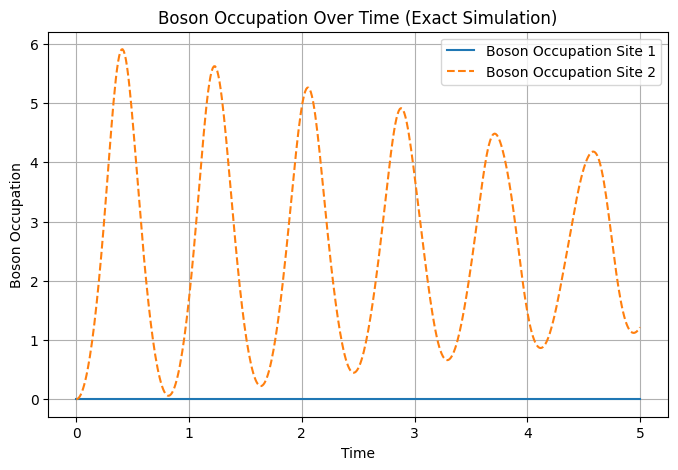

In [298]:
# Parameters 
num_sites = 2
num_qubits_per_qumode = 3  
b = 1
m = 1
g = 5 * np.sqrt(2)
eps1 = 3.297
eps2 =  1
t_max = 5.0

dt_exact = 0.01
num_steps_exact = int(t_max / dt_exact) + 1
times_exact = np.linspace(0, t_max, num_steps_exact)

result_exact = qutip_2site_yukawa(b=b, m_psi=m, g=g, epsilon1=eps1, epsilon2=eps2,
                                  N_b=2**num_qubits_per_qumode, t_max=t_max, num_steps=num_steps_exact)
fermion_pop1_exact, fermion_pop2_exact, boson_occ1_exact, boson_occ2_exact = compute_expectations_qutip(result_exact.states, N_b=2**num_qubits_per_qumode)

plt.figure(figsize=(8, 5))
plt.plot(times_exact, boson_occ1_exact, label="Boson Occupation Site 1")
plt.plot(times_exact, boson_occ2_exact, label="Boson Occupation Site 2", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Boson Occupation")
plt.title("Boson Occupation Over Time (Exact Simulation)")
plt.legend()
plt.grid(True)
plt.show()